# 03 Semantic Segementation

In [1]:
!pip install wget #For colab

In [2]:
import wget, argparse, zipfile, tarfile, sys
from pathlib import Path

def simple_progress_bar(current, total, width=80):
    progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    sys.stdout.write("\r" + progress_message); sys.stdout.flush()

def get_and_unpack(url, location='data/'):
    Path(location).mkdir(exist_ok=True)
    filename = wget.download(url, out=location, bar=simple_progress_bar)
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall(path=location)
    zip_ref.close()

In [3]:
get_and_unpack(url='http://www.welchlabs.io/unccv/deep_learning/bbc_train.zip')

Downloading: 67% [61300736 / 90591239] bytes

- But wait, there's more! 
- Let's explore one more type of problem we can solve using a very similar architecture: **semantic segmentation**. 
- Our goal in semantic segmentation is to assign each pixel to a specific class. 
- Now is a good time to start thinking about what type of dimension we need for the output of our nueral network in order to solve this problem.

In [4]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

### 1. Data

In [5]:
path=Path('data/bbc_train')

In [6]:
path.ls()

[PosixPath('data/bbc_train/bboxes.json'),
 PosixPath('data/bbc_train/.DS_Store'),
 PosixPath('data/bbc_train/classification_labels.csv'),
 PosixPath('data/bbc_train/images'),
 PosixPath('data/bbc_train/masks')]

In [7]:
fnames = get_image_files(path/'images')
fnames[:3]

[PosixPath('data/bbc_train/images/P2050253.jpg'),
 PosixPath('data/bbc_train/images/P2050643.jpg'),
 PosixPath('data/bbc_train/images/P2050496.jpg')]

In [8]:
lbl_names = get_image_files(path/'masks')
lbl_names[:3]

[PosixPath('data/bbc_train/masks/P2050525.png'),
 PosixPath('data/bbc_train/masks/P2050850.png'),
 PosixPath('data/bbc_train/masks/P2050871.png')]

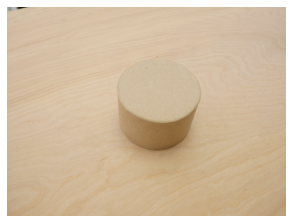

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
def get_y_fn(x): return path/'masks'/(x.stem + '.png')
classes = array(['background', 'brick', 'ball', 'cylinder'])

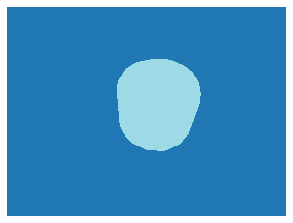

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
unique(mask.data)

array([0, 3])

In [13]:
src = (SegmentationItemList.from_folder(path/'images')
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=classes))

In [14]:
data = (src.transform(get_transforms(), tfm_y=True, size=(256,256))
        .databunch(bs=16)
        .normalize(imagenet_stats))

In [15]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/bbc_train/images;

Valid: LabelList (188 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/bbc_train/images;

Test: None

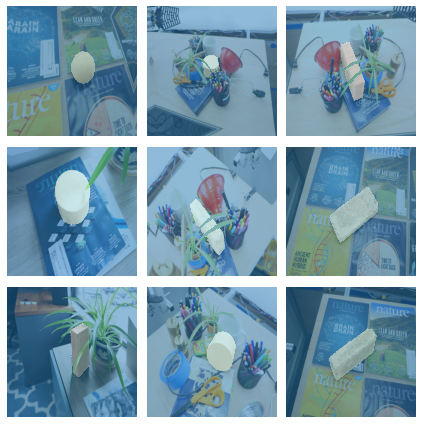

In [16]:
data.show_batch(3, figsize=(6,6))

### 2. Model

- Now, as you may have guessed we need to implement another custom head. 
- However, this time we need a slightly more complicated architecture for this portion of our network. 
- The challenge here is that we need to **upsample**, or make our tensors larger as they pass through the network. 
- We can achieve this using a special operation called a **transposed convoulation** - we'll dig more into the details of this operation later. 
- The thing to know for knwo is that transposed convulutional layers in our neural network allow us to learn an "upsampling" or mapping form smaller to larger tensors. 

In [17]:
def conv_trans(ni, nf, ks = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding), 
        nn.ReLU(inplace = True), 
        nn.BatchNorm2d(nf))

In [18]:
custom_head=nn.Sequential(conv_trans(512, 256), 
                          conv_trans(256, 128),
                          conv_trans(128, 64),
                          conv_trans(64, 32), 
                          nn.ConvTranspose2d(32, 4, kernel_size=4, bias=False, stride=2, padding = 1))

- We need to intorduce a slightly specialized performance measure here, the accuracy evaluate pixel by pixel (like we're solving a classification problem for each pixel!

In [19]:
def pixel_accuracy(yhat, y):
    y_=y.squeeze(dim=1)
    yhat_=yhat.argmax(dim=1)
    return (y_==yhat_).sum().float()/y.numel()

In [20]:
learn=cnn_learner(data, models.resnet18, custom_head=custom_head, metrics=pixel_accuracy)

In [21]:
learn.freeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


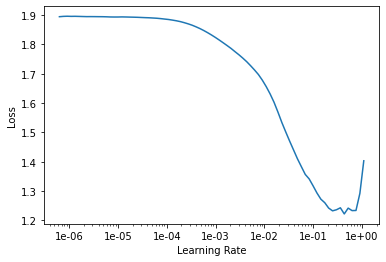

In [23]:
learn.recorder.plot()

In [ ]:
lr=1e-2
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.889256,0.457757,0.935697,02:33
1,0.344428,0.104861,0.961266,03:43
2,0.184321,0.087698,0.967073,03:43


In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr=1e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

In [ ]:
learn.save('basic-segmentation')

### 3. Results

In [ ]:
def blend_image_mask(im, mask, alpha=0.7):
    im_mask=np.zeros((im.shape[1], im.shape[2], 3), dtype='float32')
    for j in range(3): im_mask[:,:,j]=im.mean(axis=0)
    for j in range(1, 4):
        im_mask[mask==j] = alpha*im_mask[mask==j] + (1-alpha)*np.array([float(i==(j-1)) for i in range(3)])
    return im_mask

In [ ]:
def make_legend():
    custom_lines = [Line2D([0], [0], color='r', lw=2, alpha=0.5),
                    Line2D([0], [0], color='g', lw=2, alpha=0.5),
                    Line2D([0], [0], color='b', lw=2, alpha=0.5)]

    legend(custom_lines, ['Brick', 'Ball', 'Cylinder'])

In [ ]:
denorm=learn.data.denorm

In [ ]:
with torch.no_grad():
    x,y = next(iter(learn.data.valid_dl))
    yhat = to_np(learn.model(x))
    x=denorm(x)

In [ ]:
x.shape, y.shape, yhat.shape

In [ ]:
yhat=yhat.argmax(1)

In [ ]:
fig=figure(0, (20, 10))

for i in range(8):
    fig.add_subplot(2,4,i+1)
    im_mask=blend_image_mask(x[i], yhat[i])
    imshow(im_mask); axis('off'); make_legend()

## Save Model Weights

In [ ]:
learn.export('/home/bbc-semantic-segmentation.pkl')